In [106]:
!pip install yfinance
!pip install arch


In [107]:
import requests
import pandas as pd
import os
import yfinance as yf
import numpy as np
from arch import arch_model
from scipy.optimize import minimize
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns


# Partie I - Collecte et traitement des données

1. Téléchargement des données

*1.1. Téléchargement des données à l'aide de l'API*

Nous allons utiliser une API générée à partir d'Alpha Vantage pour télécharger des données boursières historiques mensuelles de grandes entreprises technologiques : Apple, Microsoft, Google, Amazon et Meta. Ces entreprises ont été choisies pour leur rôle de leaders dans l'industrie technologique, leur influence significative sur les indices boursiers mondiaux, et leur pertinence en tant qu'indicateurs de la santé économique du secteur. Les données téléchargées couvrent un intervalle de temps d’un mois, permettant une analyse des tendances globales tout en éliminant le bruit des variations quotidiennes. Ce choix d'intervalle est particulièrement adapté aux analyses à moyen ou long terme.


Pour optimiser le processus de téléchargement des données, nous avons créé une fonction appelée `download_data`. Cette fonction prend en entrée le nom de l'entreprise (`company_name`) et les paramètres nécessaires à l'API (`params`). Elle centralise la logique de téléchargement et de sauvegarde des données pour éviter de réécrire le même code à chaque requête pour les différentes entreprises.


In [108]:
# URL et clé API
url = "https://www.alphavantage.co/query"
api_key = "O0S7MV4XE2PDKBDF"

# Liste des symboles
symbols = {
    "apple": {"function": "TIME_SERIES_MONTHLY", "symbol": "AAPL"},
    "microsoft": {"function": "TIME_SERIES_MONTHLY", "symbol": "MSFT"},
    "google": {"function": "TIME_SERIES_MONTHLY", "symbol": "GOOGL"},
    "amazon": {"function": "TIME_SERIES_MONTHLY", "symbol": "AMZN"},
    "meta": {"function": "TIME_SERIES_MONTHLY", "symbol": "META"}
}

def download_data(company_name, params):
    params["apikey"] = api_key
    params["datatype"] = "csv"
    response = requests.get(url, params=params)

    if response.status_code == 200:
        filename = os.path.join("/home/onyxia/work/projet_gold_refuge/all_data_used", f"{company_name}_data.csv")
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Les données de {company_name} ont été sauvegardées dans {filename}.")
    else:
        print(f"Erreur pour {company_name}: {response.status_code}, {response.text}")

# Télécharger les données historiques
for company, params in symbols.items():
    download_data(company, params)


Les données de apple ont été sauvegardées dans /home/onyxia/work/projet_gold_refuge/all_data_used/apple_data.csv.
Les données de microsoft ont été sauvegardées dans /home/onyxia/work/projet_gold_refuge/all_data_used/microsoft_data.csv.
Les données de google ont été sauvegardées dans /home/onyxia/work/projet_gold_refuge/all_data_used/google_data.csv.
Les données de amazon ont été sauvegardées dans /home/onyxia/work/projet_gold_refuge/all_data_used/amazon_data.csv.
Les données de meta ont été sauvegardées dans /home/onyxia/work/projet_gold_refuge/all_data_used/meta_data.csv.


*2.2. Téléchargement des données sur Yahoo Finance*

Dans cette section, nous utilisons la bibliothèque `yfinance` pour télécharger des données historiques mensuelles des actifs financiers, dont on a besoin:  l'Or, le Bitcoin, l'Ethereum et l'indice S&P 500, sur une plage temporelle allant de 2000 à 2024. Le S&P 500 a été choisi comme indicateur de la performance des grandes entreprises américaines.


In [109]:
assets = {
    "Gold": "GC=F",        # Gold Futures
    "Bitcoin": "BTC-USD",  # Bitcoin en USD
    "Ethereum": "ETH-USD", # Ethereum en USD
    "S&P 500": "^GSPC"     # S&P 500 Index
}

# La plage de dates
start_date = "2000-01-01"
end_date = "2024-12-01"

# Télécharger les données pour chaque actif
for asset_name, ticker in assets.items():
    print(f"Téléchargement des données pour {asset_name} ({ticker})...")
    
    # Télécharger les données avec yfinance
    data = yf.download(ticker, start=start_date, end=end_date, interval="1mo")
    
    # Sauvegarder dans un fichier CSV
    filename = os.path.join("/home/onyxia/work/projet_gold_refuge/all_data_used", f"{asset_name.lower()}_historical_data.csv")
    data.to_csv(filename)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour Gold (GC=F)...
Téléchargement des données pour Bitcoin (BTC-USD)...
Téléchargement des données pour Ethereum (ETH-USD)...
Téléchargement des données pour S&P 500 (^GSPC)...


3. Création et nettoyage de la base de données 

*3.1. Création et réorganisation de la base de données à l'aide des fichiers téléchargés* 

Dans cette section, nous créons la base de données avec laquelle nous allons travailler. Nous allons commencer avec les données des actions des entreprises. Un DataFrame principal est initialisé avec une plage de dates mensuelles allant de janvier 2000 à décembre 2024. Chaque fichier CSV des entreprises est ensuite chargé individuellement, et son contenu est transformé : le nom de l'entreprise est extrait du nom du fichier, la colonne de timestamp est convertie en format datetime, et une colonne représentant les mois est ajoutée. Les données brutes téléchargées précédemment contiennent trois valeurs principales pour les actions : 
- **Open** : Le prix de l'action à l'ouverture du marché.
- **High** : Le prix le plus élevé atteint par l'action.
- **Low** : Le prix le plus bas atteint par l'action.

Pour estimer le prix moyen d'une action sur un mois, nous avons choisi de calculer la moyenne entre les valeurs `High` et `Low`. Ce choix permet de refléter une approximation réaliste des fluctuations du prix sans être biaisé par les pics ou creux extrêmes. Le volume d'actions échangées est conservé. Les colonnes traitées sont renommées pour inclure le nom de l'entreprise, ce qui permet une distinction claire lors de la fusion des données. 

Il est important de noter que les données téléchargées pour les actions des entreprises et les actifs commencent à des dates différentes. Cependant, notre analyse couvre une période fixe de 2000 à 2024. Les données manquantes dans cette plage de dates sont marquées comme `NaN`, et ces valeurs seront traitées ultérieurement dans la partie dédiée au nettoyage des données. Par exemple, l'entreprise META, créée en 2004, est considérée ici comme ayant été créée dès 2000, avec des valeurs manquantes (`NaN`) pour la période 2000-2004, qui seront également gérées dans la phase de nettoyage.


In [110]:
# Liste des fichiers CSV des entreprises
companies= ["amazon_data.csv",
    "apple_data.csv",
    "google_data.csv",
    "meta_data.csv",
    "microsoft_data.csv"
]

# Créer un DataFrame principal avec toutes les dates possibles de 2000 à 2024
date_range = pd.date_range(start="2000-01", end="2024-12", freq="M")
final_df = pd.DataFrame({'year_month': date_range.to_period('M')})

for file in companies:
    # Charger les données
    df = pd.read_csv("all_data_used/"+ file)

    # Récupérer le nom de l'entreprise
    company_name = file.replace("_data.csv", "").replace(".csv", "").replace(" ", "")

    # Convertir la colonne timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ajouter une colonne année-mois
    df['year_month'] = df['timestamp'].dt.to_period('M')

    # Calculer le prix des actions 
    df = df[['year_month', 'high', 'low', 'volume']]
    df[f'{company_name}_stock_price'] = (df['high'] + df['low']) / 2
    df[f'{company_name}_stock_volume'] = df['volume']

    # Garder uniquement les colonnes de la société traitée
    df = df[['year_month', f'{company_name}_stock_price', f'{company_name}_stock_volume']]

    # Supprimer les colonnes existantes dans final_df avant fusion
    for col in [f'{company_name}_stock_price', f'{company_name}_stock_volume']:
        if col in final_df.columns:
            final_df.drop(columns=col, inplace=True)

    # Fusionner directement avec le DataFrame principal
    final_df = pd.merge(final_df, df, on='year_month', how='left')

/tmp/ipykernel_13801/366641353.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start="2000-01", end="2024-12", freq="M")


In [111]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume
0,2000-01,74.970,262209000,104.000,112099800,NaN,NaN,NaN,NaN,106.745,637437600
1,2000-02,74.500,207457700,108.470,65355200,NaN,NaN,NaN,NaN,99.060,667243800
2,2000-03,67.625,156584600,132.190,77663900,NaN,NaN,NaN,NaN,101.970,1014093800
3,2000-04,54.720,162012500,122.185,77342900,NaN,NaN,NaN,NaN,80.750,1129073300
4,2000-05,51.410,130688600,104.000,87569200,NaN,NaN,NaN,NaN,67.190,672215400


Maintenant, nous allons intégrer les données des actifs financiers (Bitcoin, Ethereum, or, et S&P 500) dans la base principale. Chaque fichier CSV est chargé en ignorant les lignes inutiles. Les colonnes pertinentes (`Date`, `High`, `Low`, `Volume`) sont sélectionnées puis renommées pour assurer une uniformité avec les autres données. Une colonne `year_month` est ajoutée pour grouper les données par mois, et le prix moyen de chaque actif est calculé comme valeur moyenne de `High` et `Low`. Les données des actifs, bien qu'elles commencent à des dates différentes, sont alignées sur la période 2000-2024, avec des valeurs manquantes (`NaN`) ajoutées pour les mois absents. Ces données manquantes seront traitées dans la phase de nettoyage.


In [112]:
element_files = [
    "bitcoin_historical_data.csv",
    "ethereum_historical_data.csv",
    "gold_historical_data.csv",
    "s&p 500_historical_data.csv"
]
# Boucle sur chaque fichier d'éléments
for file in element_files:
    # Charger les données en ignorant les deux premières lignes inutiles
    df = pd.read_csv("all_data_used/"+ file, skiprows=2)

    # Récupérer le nom de l'élément
    element_name = file.replace("_historical_data.csv", "").replace(".csv", "").replace(" ", "").lower()

    # Renommer les colonnes en utilisant leur position
    df = df.iloc[:, [0, 2, 3, 5]]  # Sélectionne les colonnes Date, High, Low, Volume
    df.columns = ["timestamp", "high", "low", "volume"]  # Renommer pour uniformité

    # Convertir la colonne timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ajouter une colonne année-mois
    df['year_month'] = df['timestamp'].dt.to_period('M')

    # Calculer le prix moyen
    df[f'{element_name}_price'] = (df['high'] + df['low']) / 2
    df[f'{element_name}_volume'] = df['volume']

    # Garder uniquement les colonnes nécessaires
    df = df[['year_month', f'{element_name}_price', f'{element_name}_volume']]

    # Supprimer les colonnes existantes avant fusion
    for col in [f'{element_name}_price', f'{element_name}_volume']:
        if col in final_df.columns:
            final_df.drop(columns=col, inplace=True)

    # Fusionner avec le DataFrame principal
    final_df = pd.merge(final_df, df, on='year_month', how='left')


In [113]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,NaN,NaN,NaN,NaN,106.745,637437600,NaN,NaN,NaN,NaN,NaN,NaN,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,NaN,NaN,NaN,NaN,99.060,667243800,NaN,NaN,NaN,NaN,NaN,NaN,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,NaN,NaN,NaN,NaN,101.970,1014093800,NaN,NaN,NaN,NaN,NaN,NaN,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,NaN,NaN,NaN,NaN,80.750,1129073300,NaN,NaN,NaN,NaN,NaN,NaN,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,NaN,NaN,NaN,NaN,67.190,672215400,NaN,NaN,NaN,NaN,NaN,NaN,1421.299988,19898300000


In [114]:
file_path = os.path.join("/home/onyxia/work/projet_gold_refuge/all_data_used", "final_combined_data.csv")
# Sauvegarder le DataFrame dans le fichier CSV
final_df.to_csv(file_path, index=False)
print(f"Le DataFrame final a été sauvegardé dans '{file_path}'.")

Le DataFrame final a été sauvegardé dans '/home/onyxia/work/projet_gold_refuge/all_data_used/final_combined_data.csv'.


*3.2. Traitement des valeurs manquantes*

Dans cette section, nous allons traiter les valeurs manquantes. Commençons d'abord par regarder le nombre de valeurs manquantes existantes dans notre base de données. 

In [115]:
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")


Nombre total de valeurs manquantes dans final_df : 1294


*3.2.1. Premier cas*

Cette partie traite exclusivement des valeurs manquantes dans les colonnes numériques lorsque celles-ci contiennent au moins une valeur existante pour l'année concernée. Dans ces cas, les valeurs manquantes sont remplacées par la moyenne annuelle calculée à partir des données disponibles de la même année. Cette méthode garantit que les remplacements respectent les spécificités temporelles des données, en reflétant les tendances propres à chaque année, tout en évitant les biais liés à des variations interannuelles. Si une colonne est entièrement vide pour une année donnée, les valeurs manquantes ne sont pas modifiées. Ces valeurs seront traitées dans le second cas par la suite. 

In [116]:
# Vérifier les colonnes avec des valeurs numériques uniquement
numeric_columns = final_df.select_dtypes(include=['float64', 'int64']).columns

# Remplacer les valeurs manquantes par la moyenne annuelle si possible
for col in numeric_columns:
    # Calculer la moyenne annuelle pour chaque colonne en ignorant les NaN
    annual_mean = final_df.groupby(final_df['year_month'].dt.year)[col].transform('mean')
    
    # Remplacer les NaN par la moyenne annuelle calculée
    final_df[col] = final_df[col].fillna(annual_mean)


In [117]:
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")

Nombre total de valeurs manquantes dans final_df : 1128


*3.2.2. Second cas*

Pour les valeurs manquantes qui restent après le traitement précédent, nous les remplaçons par la moyenne globale de toute la colonne.

In [118]:
for col in numeric_columns:
    # Calculer la moyenne globale en ignorant les NaN
    global_mean = final_df[col].mean()
    
    # Remplacer les NaN restants par la moyenne globale
    final_df[col] = final_df[col].fillna(global_mean)

In [119]:
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,760.629032,1.979314e+08,177.585127,6.236496e+08,106.745,637437600,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,760.629032,1.979314e+08,177.585127,6.236496e+08,99.060,667243800,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,760.629032,1.979314e+08,177.585127,6.236496e+08,101.970,1014093800,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,760.629032,1.979314e+08,177.585127,6.236496e+08,80.750,1129073300,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,760.629032,1.979314e+08,177.585127,6.236496e+08,67.190,672215400,17705.370867,5.175726e+11,1382.316098,3.549254e+11,270.916667,12806.666667,1421.299988,19898300000


In [120]:
missing_values_count = final_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes dans final_df : {missing_values_count}")

Nombre total de valeurs manquantes dans final_df : 0



Ainsi, après les étapes de collecte, réorganisation et nettoyage des données brutes, notre base de données est désormais complète et prête pour la phase descriptive et la modélisation.

# Partie II - Partie descriptive

Cette partie a pour objectif de décrire et interpréter les fluctuations de l'or et des principales cryptomonnaies et actions sur les marchés financiers, afin d'analyser si l'or et les cryptomonnaies correspondent aux critères remplis par une valeur refuge. Une valeur refuge est un actif particulièrement demandé lors des périodes de crises parce qu'il est réputé pour conserver sa valeur dans le temps malgré l'instabilité du contexte économique et financier. Ce type d'actif remplit les critères suivants :
- Il dégage des rendements non corrélés à ceux des actions en période de crise
- Il joue un rôle de couverture en dégageant des rendements non corrélés sur le long terme.  

L'or est un actif financier traditionnellement considéré comme une valeur refuge, dans la mesure où il joue un rôle de réserve de valeur de long terme en période de crise. Au contraire, les cryptommonnaies comme le Bitcoin sont considérés dans la littérature économique comme une mauvaise réserve de valeur du fait de leur forte volatilité et de l'absence de garantie de sa valeur nominale par une instance publique ou privée. Une étude conduite par T. Moore et N. Christin en 2013, citée par J.M. Figuet, montre que sur les 40 plateformes d'échange de bitcoin étudiées, 18 ont fermé, entraînant dans près de la moitié des cas des pertes pour les déposants. En août 2016, Bitfinex a été victime d’un piratage informatique impliquant la perte de 120 000 bitcoins. Ainsi, les cryptomonnaies apparaissent être des actifs financiers particulièrement risqués et peu fiables, ce qui apparaît remettre en cause leur capacité à être une valeur refuge. Dans la presse ces derniers mois, les cryptomonnaies sont toutefois décrites comme de nouvelles valeurs refuges. 

Les données financières étudiées, entre 2000 et 2024, permettent d'étudier si dans les faits l'or et les cryptomonnaies sont des valeurs refuges. 

1. Travail préliminaire d'aide à la visualisation

*1.1. Affichage des données*

Afin de faciliter la visualisation, on conserve trois décimales pour le prix des actions pour lesquelles ce n'est pas déjà le cas. On conserve six décimales pour le prix des cryptomonnaies. En effet, les cryptomonnaies sont divisibles en très petites unités ; réduire le nombre de décimales serait donc synonyme de perte d'information.

In [121]:
# Arrondir le prix des actions à 3 décimales lorsque nécessaire 
final_df = final_df.round({'amazon_stock_price': 3, 'google_stock_price': 3, 'meta_stock_price': 3})


On effectue également des modifications sur le volume en évitant l'écriture scientifique pour plus de lisibilité. 

In [122]:
# Fonction pour convertir les colonnes spécifiées en entiers
def convert_to_int(df, columns):
    df[columns] = df[columns].astype(int)
    return df

In [123]:
# On utilise alors la fonction avec la liste des colonnes à convertir suivante:
columns_converted = ['google_stock_volume', 'ethereum_volume', 'bitcoin_volume', 's&p500_volume', 'meta_stock_volume']

# Application de la fonction à final_df
final_df = convert_to_int(final_df, columns_converted)

# Afficher les premières lignes du df modifié 
final_df.head()

,year_month,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
0,2000-01,74.970,262209000,104.000,112099800,760.629,197931417,177.585,623649587,106.745,637437600,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1414.070007,21494400000
1,2000-02,74.500,207457700,108.470,65355200,760.629,197931417,177.585,623649587,99.060,667243800,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1384.809998,20912000000
2,2000-03,67.625,156584600,132.190,77663900,760.629,197931417,177.585,623649587,101.970,1014093800,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1449.744995,26156200000
3,2000-04,54.720,162012500,122.185,77342900,760.629,197931417,177.585,623649587,80.750,1129073300,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1433.294983,20106460000
4,2000-05,51.410,130688600,104.000,87569200,760.629,197931417,177.585,623649587,67.190,672215400,17705.370867,517572575203,1382.316098,354925375295,270.916667,12806.666667,1421.299988,19898300000


*1.2. Premières statistiques descriptives*


On affiche dans un premier temps les statistiques descriptives pour l'ensemble des variables sur toute la période considérée. 

In [124]:
final_df.describe()

,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
count,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,299.000000,299.000000,2.990000e+02
mean,596.030870,2.338483e+08,174.491543,6.998301e+08,760.629023,1.979314e+08,177.585080,6.236496e+08,95.281551,9.467717e+08,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1130.947491,86970.130202,2089.054264,7.019747e+10
std,926.010738,3.250052e+08,146.158314,5.723511e+08,556.747755,1.904352e+08,90.532894,2.539357e+08,106.370793,4.192055e+08,13593.217299,3.559801e+11,652.536490,1.561093e+11,583.686008,106398.638197,1218.513567,2.891918e+10
min,7.430000,4.346880e+07,13.835000,6.535520e+07,92.190000,2.304129e+07,20.240000,2.261357e+08,16.875000,3.423704e+08,238.188499,5.531023e+08,120.249294,4.445981e+10,261.949997,893.000000,749.884979,1.908910e+10
25%,46.572500,8.275704e+07,77.362500,2.987677e+08,453.977500,4.281145e+07,157.200000,5.049505e+08,27.612500,6.061426e+08,10764.107300,5.175726e+11,1382.316098,3.549254e+11,603.750000,9102.500000,1198.367462,4.829011e+10
50%,166.420000,1.333624e+08,140.775000,5.620912e+08,688.650000,1.458872e+08,177.585000,6.236496e+08,46.980000,8.593311e+08,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1230.500000,19001.400000,1475.320007,7.561031e+10
75%,658.722500,1.916486e+08,204.112500,9.000309e+08,858.920000,2.303744e+08,177.585000,6.236496e+08,105.185000,1.272418e+09,17705.370867,5.175726e+11,1382.316098,3.549254e+11,1608.324982,157753.000000,2712.147522,8.618484e+10
max,3540.029000,2.035252e+09,680.535000,3.886793e+09,2925.680000,9.527097e+08,582.235000,2.032635e+09,440.280000,3.044579e+09,83229.574219,2.267153e+12,4412.605591,1.510330e+12,2695.750000,443701.000000,5870.339844,1.621854e+11


A noter que le premier mois pour lequel on a pu collecter les données sont:
- Pour Google : 2004-09
- Pour Meta : 2012-06
- Pour l'Ethereum: 2017-12
- Pour le Bitcoin: 2014-10
- Pour l'or: 2000-09

On effectue également l'analyse à partir du mois de décembre 2017 pour avoir les statistiques les plus récentes avec toutes les données disponibles.

In [125]:
# Filtrage des données postérieures à décembre 2017
latest_data = final_df[final_df['year_month'] >= '2017-12']

# Statistiques descriptives sur les données les plus récentes 
latest_data.describe()

,amazon_stock_price,amazon_stock_volume,apple_stock_price,apple_stock_volume,google_stock_price,google_stock_volume,meta_stock_price,meta_stock_volume,microsoft_stock_price,microsoft_stock_volume,bitcoin_price,bitcoin_volume,ethereum_price,ethereum_volume,gold_price,gold_volume,s&p500_price,s&p500_volume
count,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,84.00000,84.000000,8.400000e+01
mean,1594.253667,4.697608e+08,187.072438,1.282012e+09,1145.468440,2.387685e+08,259.706262,4.777404e+08,238.366378,5.961304e+08,27046.966609,8.010751e+11,1478.453297,3.909455e+11,1745.663167,107779.49145,3791.361604,8.687678e+10
std,1228.862564,5.396450e+08,52.987103,6.516978e+08,885.194366,2.874301e+08,112.895236,1.914812e+08,104.984100,1.768703e+08,20394.128314,4.773935e+11,1203.331925,2.759660e+11,348.589170,118724.77008,892.269236,1.591233e+10
min,89.460000,5.206047e+07,114.655000,3.938439e+08,92.190000,2.304129e+07,103.415000,2.261357e+08,84.099950,3.423704e+08,3750.340454,1.184369e+11,120.249294,4.445981e+10,1192.549988,4126.00000,2573.380005,6.303151e+10
25%,175.215000,7.801962e+07,149.620000,7.381035e+08,160.786750,3.362435e+07,179.716250,3.341730e+08,138.373750,4.801091e+08,9139.994873,4.686604e+11,278.960136,1.999103e+11,1403.262502,9281.75000,2913.869934,7.762015e+10
50%,1723.557500,1.144326e+08,174.112500,1.185673e+09,1167.820000,4.132788e+07,216.230000,4.400423e+08,236.045000,5.624099e+08,22068.976562,7.729387e+11,1430.734009,3.697663e+11,1793.075043,35064.50000,3874.002502,8.243948e+10
75%,2930.565000,9.361697e+08,207.103750,1.684877e+09,1559.839000,5.371061e+08,316.000750,5.534249e+08,310.186250,6.690356e+08,42547.661621,1.051473e+12,2369.349976,5.218055e+11,1935.687500,196233.00000,4393.913879,9.240001e+10
max,3540.029000,2.035252e+09,391.120000,3.886793e+09,2925.680000,9.527097e+08,582.235000,1.127891e+09,440.280000,1.612954e+09,83229.574219,2.267153e+12,4412.605591,1.510330e+12,2695.750000,443701.00000,5870.339844,1.621854e+11


On remarque que les actions Amazon, Google et Meta, Microsoft ainsi que le Bitcoin et l'or ont connu leur maximum historique entre fin 2017 et 2024. Google a également atteint son prix minimal pendant la période la plus récente. Pour toutes les autres actions et pour l'or et les cryptomonnaies créées avant 2017, le prix minimum a été atteint avant décembre 2017. On observe donc une tendance de décalage vers le haut du prix minimal. Pour le Bitcoin, on remarque que le prix minimal sur la période récente (20394.128314$) est bien supérieur à celui sur la période antérieure à décembre 2017 (238.188499$), ce qui montre l'attrait croissant pour la détention pour le Bitcoin au fil des années. 

*1.3. Premières représentations graphiques*

On représente dans un premier temps le prix des différentes cryptomonnaies et de l'or depuis décembre 2017.

In [126]:
column_type = latest_data['year_month'].dtype
print(f"Le type de 'year_month' est : {column_type}")

Le type de 'year_month' est : period[M]


In [127]:
latest_data['year_month'] = latest_data['year_month'].dt.to_timestamp()

/tmp/ipykernel_13801/2238360883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['year_month'] = latest_data['year_month'].dt.to_timestamp()


In [128]:
# Fonction pour déterminer le mois où une variable a atteint son maximum historique 
def get_month_with_max_price(dataframe, price_column, date_column='year_month'):
    """
    Retourne le mois où une colonne de prix atteint sa valeur maximale.
    
    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les données.
        price_column (str): Le nom de la colonne de prix.
        date_column (str): Le nom de la colonne de date, par défaut 'year_month'.
    
    Returns:
        str: La valeur de la colonne de date correspondant au prix maximal.
    """
    max_price_row = dataframe[dataframe[price_column] == dataframe[price_column].max()]
    if not max_price_row.empty:
        return max_price_row[date_column].values[0]
    return None

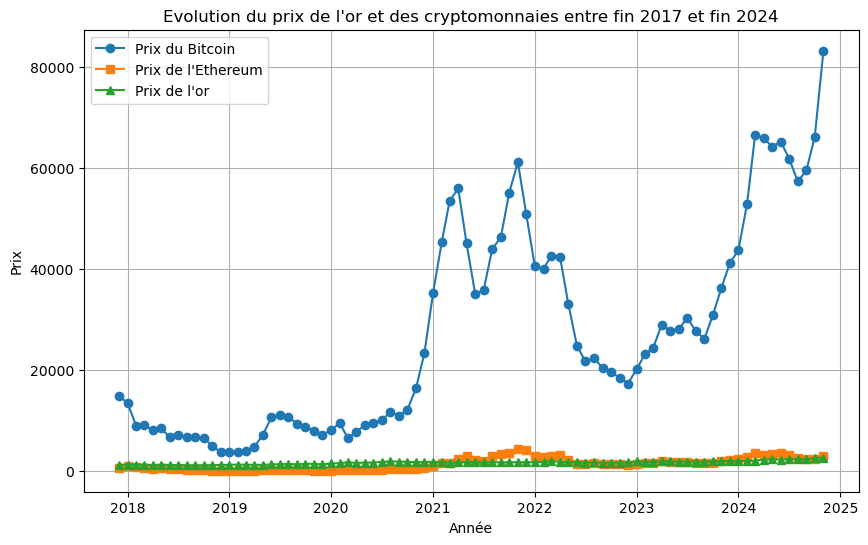

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(latest_data['year_month'], latest_data['bitcoin_price'], label='Prix du Bitcoin', marker='o')  # Courbe pour le Bitcoin
plt.plot(latest_data['year_month'], latest_data['ethereum_price'], label="Prix de l'Ethereum", marker='s')  # Courbe pour l'Ethereum
plt.plot(latest_data['year_month'], latest_data['gold_price'], label="Prix de l'or", marker='^')  # Courbe pour l'or
plt.title("Evolution du prix de l'or et des cryptomonnaies entre fin 2017 et fin 2024")
plt.xlabel('Année')  
plt.ylabel('Prix')
plt.legend()  
plt.grid(True)  
plt.show()

In [130]:
# On détermine le mois où l'Ethereum a atteint son maximum historique
get_month_with_max_price(final_df,'gold_price')

Period('2024-10', 'M')

On observe graphiquement une forte volatilité du Bitcoin. Les tendances haussières ou baissières sont nombreuses et n'apparaissent pas durables sur le moyen terme. En 2021 par exemple, la tendance s'est ainsi inversée trois fois, avec deux périodes de forte hausse et deux périodes de forte baisse. Le cours du Bitcoin a atteint son maximum historique en octobre 2024 avec un cours de 83229.574219$.  

Dans un objectif de lisibilité, on trace un graphique avec seulement l'or et l'Ethereum pour mieux rendre compte graphiquement des variations du prix.

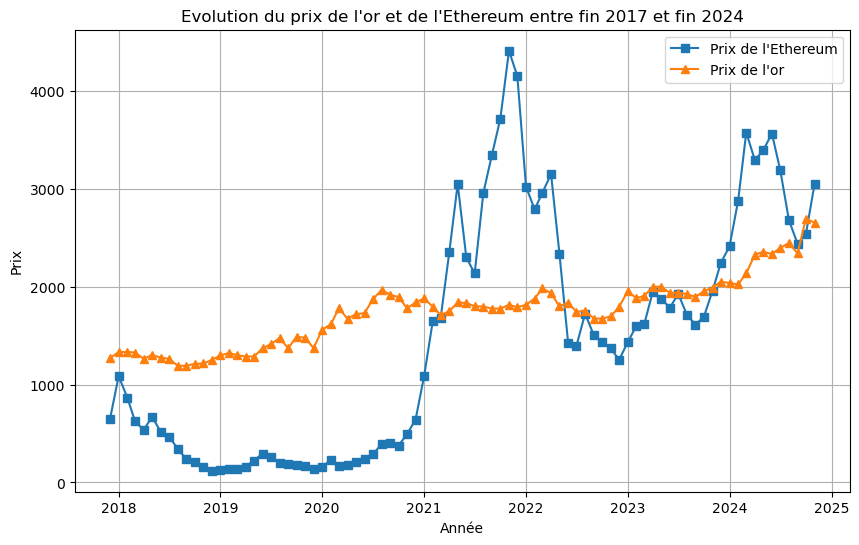

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(latest_data['year_month'], latest_data['ethereum_price'], label="Prix de l'Ethereum", marker='s')  # Courbe pour l'Ethereum
plt.plot(latest_data['year_month'], latest_data['gold_price'], label="Prix de l'or", marker='^')  # Courbe pour l'or
plt.title("Evolution du prix de l'or et de l'Ethereum entre fin 2017 et fin 2024")
plt.xlabel('Année')  
plt.ylabel('Prix')
plt.legend() 
plt.grid(True)  
plt.show()

In [132]:
# On détermine le mois où l'Ethereum a atteint son maximum historique
get_month_with_max_price(final_df,'ethereum_price')

Period('2021-11', 'M')

On remarque que le cours de l'Ethereum connaît de fortes variations sur la période considérée, avec une forte augmentation à partit de fin 2021 et un pic historique en novembre 2021. Le cours de l'or apparaît plus stable dans le temps, avec de faibles variations sur le court terme, avec une tendance haussière globale. 

2. Analyse des relations entre l'or, les cryptomonnaies et différentes variables 

*2.1. Corrélation entre les rendements de l'or, des cryptomonnaies et du marché boursier*

Les travaux de Baur et Lucey (2010) et de Baur et McDermott (2010) montrent que l'or est une valeur refuge si la corrélation entre les rendements des indices boursiers et ceux de l'or est négative ou nulle pendant les crises. On cherche alors à vérifier si cette condition est respectée pour l'or pour la période de la crise de 2008 et de la crise du COVID-19. Par extension, on examine également les résultats pour les cryptomonnaies pour la période de la crise du COVID-19. 

In [133]:
# Ajout d'une colonne avec les rendements de l'or et des cryptomonnaies dans final_df
final_df['gold_returns'] = final_df['gold_price'].pct_change()
final_df['bitcoin_returns'] = final_df['bitcoin_price'].pct_change()
final_df['ethereum_returns'] = final_df['ethereum_price'].pct_change()
final_df['s&p500_returns'] = final_df['s&p500_price'].pct_change()

On étudie la corrélation entre les rendements de l'or, des cryptomonnaies et du marché boursier pendant la crise du Covid-19. 

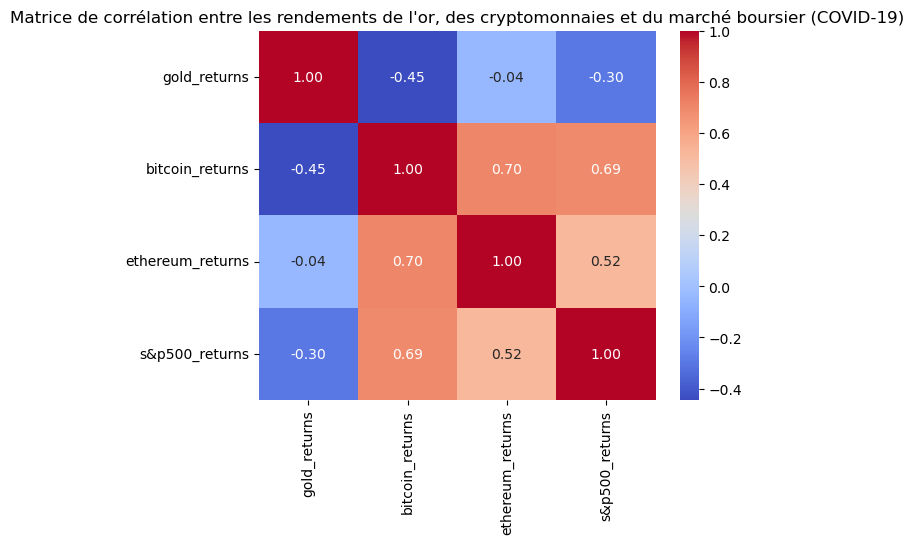

In [134]:
# Définir la période de crise COVID-19 (mars 2020 à décembre 2021)
crisis_covid_df = final_df[(final_df['year_month'] >= '2020-02') & (final_df['year_month'] <= '2020-12')]
# Matrice de corrélation
correlation_matrix_covid = crisis_covid_df[['gold_returns', 'bitcoin_returns', 'ethereum_returns', 's&p500_returns']].corr()
sns.heatmap(correlation_matrix_covid, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation entre les rendements de l'or, des cryptomonnaies et du marché boursier (COVID-19)")
plt.show()

On observe pendant la crise du COVID-19 une corrélation négative entre les rendements de l'indice du S&P 500 et ceux de l'or, -0.3 étant toutefois plus proche de 0 que de la corrélation négative parfaite, -1. Les rendements du bitcoin et de l'ethereum sont corrélés positivement à ceux de l'indice du S&P 500. une baisse des rendements sur le marché boursier a donc tendance a priori à faire augmenter les rendements de l'or et à faire baisser ceux des cryptomonnaies. 

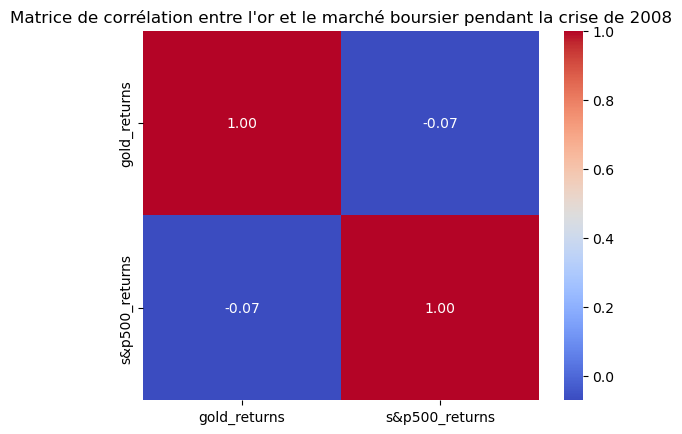

In [135]:
# Définir la période de crise de 2008 (janvier 2008 à décembre 2009)
crisis_2008_df = final_df[(final_df['year_month'] >= '2008-01') & (final_df['year_month'] <= '2009-12')]
# Matrice de corrélation
correlation_matrix_2008 = crisis_2008_df[['gold_returns', 's&p500_returns']].corr()
sns.heatmap(correlation_matrix_2008, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation entre l'or et le marché boursier pendant la crise de 2008")
plt.show()

On observe pendant la crise de 2008 une corrélation négative très proche de 0 entre les rendements de l'or et ceux de l'indice du S&P 500.

Cette première analyse à l'aide des matrices de corrélation des rendements des différents actifs en période de crise montre que l'or peut sous cette approche être considérée comme un valeur refuge, contrairement aux cryptomonnaies. 

*2.2. Relation entre volume échangé et prix*

L'objectif est d'identifier si les volumes échangés influencent les prix.

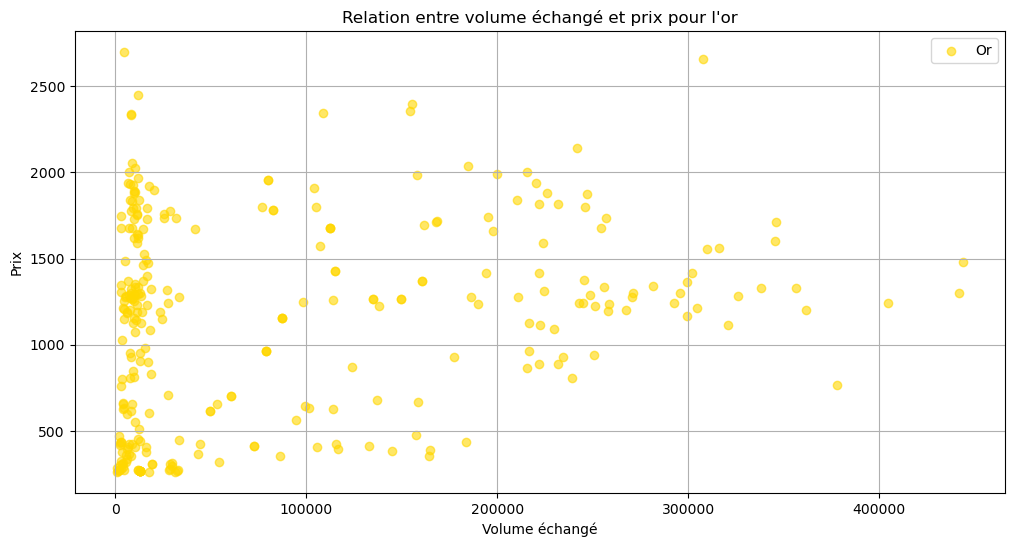

In [136]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['gold_volume'], final_df['gold_price'], label="Or", alpha=0.6, color='gold')
plt.title("Relation entre volume échangé et prix pour l'or")
plt.xlabel("Volume échangé")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()

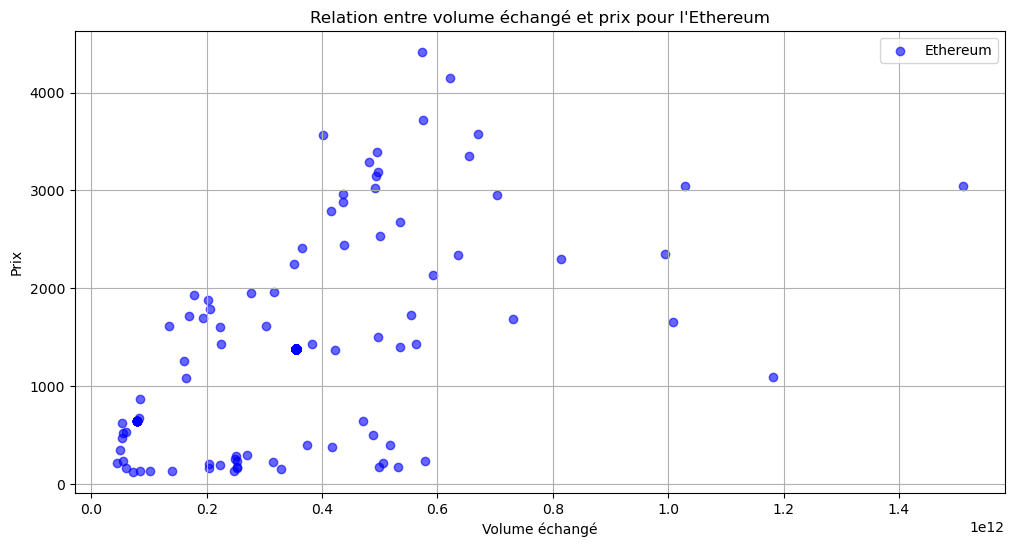

In [137]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['ethereum_volume'], final_df['ethereum_price'], label="Ethereum", alpha=0.6, color='blue')
plt.title("Relation entre volume échangé et prix pour l'Ethereum")
plt.xlabel("Volume échangé")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()

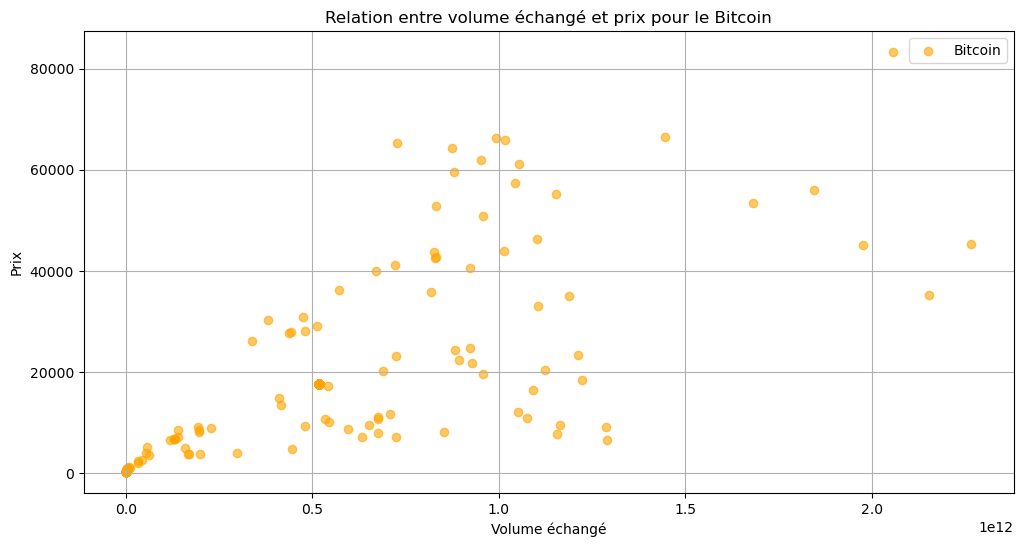

In [138]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['bitcoin_volume'], final_df['bitcoin_price'], label="Bitcoin", alpha=0.6, color='orange')
plt.title("Relation entre volume échangé et prix pour le Bitcoin")
plt.xlabel("Volume échangé")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()

On observe une forte dispersion entre volume échangé et prix pour l'or et les cryptomonnaies étudiées. Ainsi, le volume échangé ne semble pas influencer de manière prévisible le prix de ces actifs. D'autres facteurs sont en jeu. Dans le cas des actifs comme les cryptomonnaies, on peut faire l'hypothèse que cette dispersion signifie que le marché est dominé par des comportements spéculatifs. L'or étant un actif très liquide, cette dispersion peut signifier que même des volumes d'échanges élevés n'ont pas un impact direct ou visible sur le prix.

3. Analyse de la volatilité et de la performance des actifs

On fait l'hypothèse qu'une valeur refuge est peu volatile et reste toujours relativement performante, surtout en période de crise lorsque le cours des autres actifs a tendance à fortement baisser. 


*3.1. Boxplot sur la volatilité des rendements de l'or et des crytptomonnaies sur toute la période*

/tmp/ipykernel_13801/40012584.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([final_df['gold_returns'].dropna(),


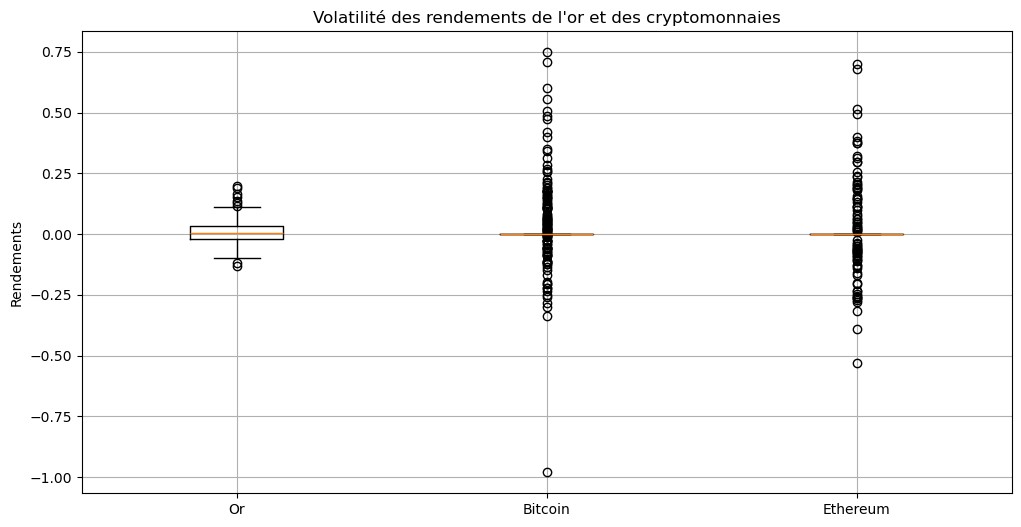

In [139]:
plt.figure(figsize=(12, 6))
plt.boxplot([final_df['gold_returns'].dropna(), 
             final_df['bitcoin_returns'].dropna(), 
             final_df['ethereum_returns'].dropna()],
            labels=["Or", "Bitcoin", "Ethereum"])
plt.title("Volatilité des rendements de l'or et des cryptomonnaies")
plt.ylabel("Rendements")
plt.grid(True)
plt.show()

La médiane pour les trois actifs est proche de zéro, ce qui suggère qu'on observe a une distribution symétrique des rendements. Les cryptomonnaies sont plus volatiles que l'or, avec une large dispersion des rendements et une présence importante de valeurs aberrantes, signe d'une forte variabilité des rendements.

*3.2. Performance des actifs financiers en période de crise*

On choisit de comparer la performance de l'or et des cryptomonnaies pendant la crise de 2020. 

TypeError: float() argument must be a string or a real number, not 'Period'

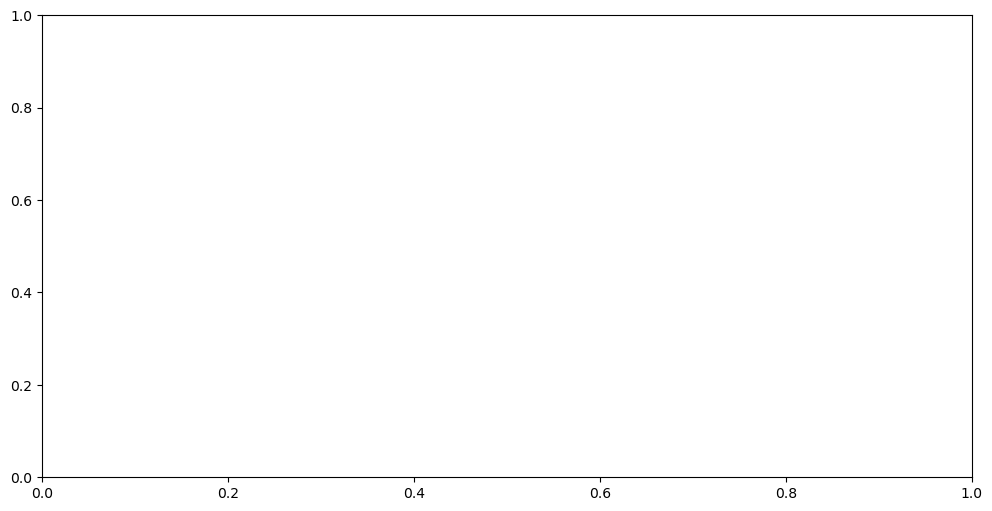

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(crisis_covid_df['year_month'], crisis_covid_df['gold_price'], label="Prix de l'Or", color='gold')
plt.plot(crisis_covid_df['year_month'], crisis_covid_df['ethereum_price'], label="Prix de l'Ethereum", color='blue')
plt.title("Evolution du prix de l'or et de l'Ethereum pendant la crise du COVID-19")
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()

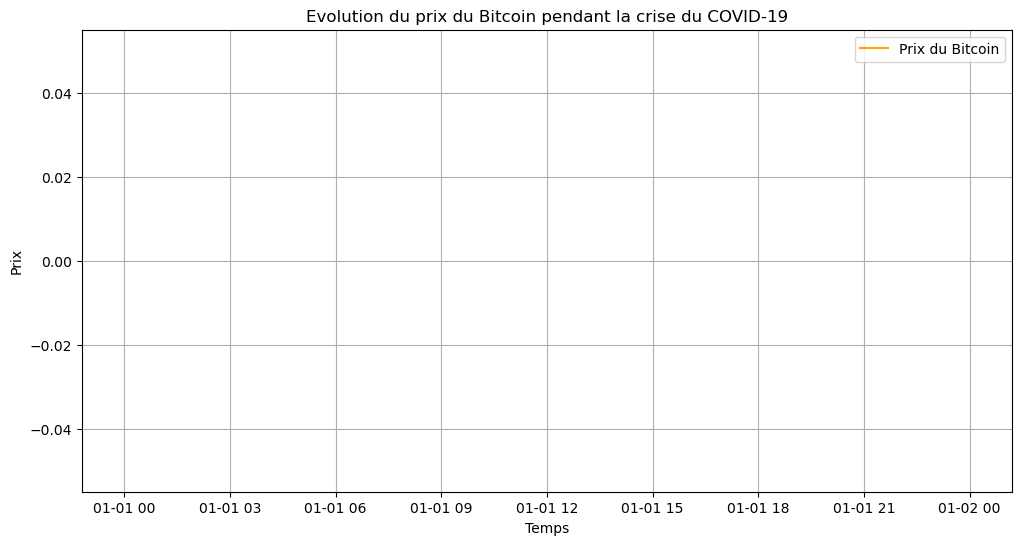

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(crisis_covid_df['year_month'], crisis_covid_df['bitcoin_price'], label="Prix du Bitcoin", color='orange')
plt.title("Evolution du prix du Bitcoin pendant la crise du COVID-19")
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()

On observe que le cours de l'or est resté relativement stable pendant la période de la crise du COVID-19, alors que celui du Bitcoin a fortement augmenté à partir d'octobre 2020. Cette tendance haussière est également observable pour l'Ethereum à partir de la même date. On ne peut toutefois pas conclure sur le caractère de valeur refuge des cryptomonnaies à partir de ces seuls graphiques : cette tendance haussière observée peut n'être que le résultat de comportements spéculatifs favorables aux cryptomonnaies et temporaires. La stabilité du cours de l'or malgré la crise et les résultats précédents laissent à penser que l'or correspond bien à une valeur refuge.

*3.3. Ratio de Sharpe*

On compare le rendement ajusté au risque des cryptomonnaies et de l'or pour évaluer la performance sur toute la période.

Le ratio de Sharpe est défini par la formule :

$$
\text{Ratio de Sharpe} = \frac{R_p - R_f}{\sigma_p}
$$

Où :
- $ R_p $ est le rendement du portefeuille ou de l'actif.
- $ R_f $ est le rendement sans risque.
- $ \sigma_p $ est l'écart-type du rendement du portefeuille (volatilité).



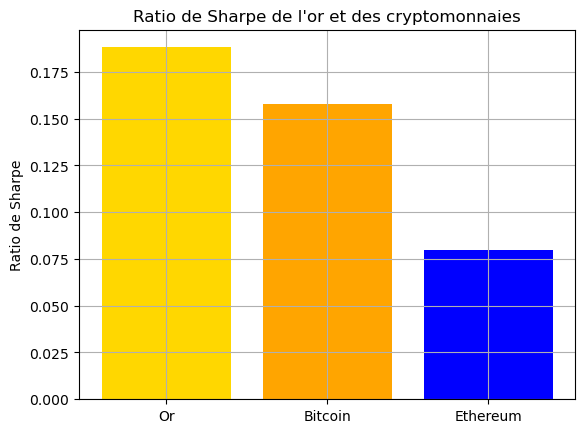

In [141]:
sharpe_ratios = {
    "Or": final_df['gold_returns'].mean() / final_df['gold_returns'].std(),
    "Bitcoin": final_df['bitcoin_returns'].mean() / final_df['bitcoin_returns'].std(),
    "Ethereum": final_df['ethereum_returns'].mean() / final_df['ethereum_returns'].std()
}
plt.bar(sharpe_ratios.keys(), sharpe_ratios.values(), color=['gold', 'orange', 'blue'])
plt.title("Ratio de Sharpe de l'or et des cryptomonnaies")
plt.ylabel("Ratio de Sharpe")
plt.grid(True)
plt.show()

On observe pour les cryptomonnaies et l'or un ratio de Sharpe positif : pour ces actifs, le rendement de l'investissement est supérieur au rendement sans risque, après ajustement pour la volatilité. Investir dans l'or génère un rendement excédentaire (au-dessus du taux sans risque) d'environ 0,18 unité pour chaque unité de risque prise. Ce ratio est d'environ 0.15 pour le bitcoin et 0.0.75 pour l'ethereum. 
Le ratio de Sharpe de l'or est le plus élevé. Ainsi l'investissement dans l'or est considéré comme plus performant en termes de rendement ajusté au risque que celui dans les cryptomonnaies. Le ratio de Sharpe de ces actifs n'est toutefois pas excellent, dans la mesure où il reste inférieur à 1 : le rendement n'excède pas le risque pris de manière significative. 

On conclut à partir de cette première approche descriptive que l'or, contrairement aux cryptomonnaies, possède les caractéristiques d'une valeur refuge en termes de corrélation des rendements avec ceux du marché boursier, de volatilité et de performance. La demande pour les cryptomonnaies en période de crise apparaît ainsi être le reflet de comportements spéculatifs plus qu'une croyance en leur capacité à conserver de la valeur, ce qui expliquerait les fluctuations plus importantes en termes de rendements et de cours observées pour ces actifs.

# Partie III- Modélisation

En bourse, un actif financier est qualifié de « valeur refuge » si sa valeur se maintienne ou augmente pendant les périodes d'incertitude économique et de turbulence du marché boursier. C’est un actif utilisé par les investisseurs pour protéger leur capital lors des périodes de crise sur les marchés. Par conséquent, la corrélation entre cet actif et les actions pendant les périodes de crise est négative.


Nous cherchons, dans une première partie, à vérifier si l’or est une valeur refuge. Pour cela, nous nous appuyons sur les travaux de Virginie Coudert et Hélène Raymond, qui ont analysé les comportements financiers de l’or à l'aide du modèle ARMA-GARCH. Ces modèles permettent d'étudier les rendements et la volatilité des actifs dans le temps, en capturant les dynamiques propres aux périodes de crises et de stabilité. 

Dans une seconde partie, nous proposons d'utiliser le même modèle afin de tester si la cryptomonnaie peut être considérée comme une valeur refuge. Pour ce faire, nous avons choisi d'analyser les deux cryptomonnaies les plus connues : le Bitcoin et l'Ethereum.

Le modèle ARMA-GARCH est utilisé pour des séries temporelles stationnaires. Comme les prix des actifs ne sont pas généralement stationnaires, les deux chercheuses utilisent le rendement logarithmique des prix qui s’écrit sous la forme $$r_t = \log\left(\frac{P_t}{P_{t-1}}\right)$$  et qui est bien stationnaire. En effet, $$\lim_{r_t \to 0} r_t = 0$$. 


Les deux chercheuses proposent de travailler avec le modèle ARMA-GARCH(1,1). L'équation représentant la dynamique des rendements des actifs est donnée par ce modèle comme : 

$$
r_t^k = c^k + a_1^k r_{t-1}^k + b_1^k \epsilon_{t-1}^k\leq 0 \quad \quad \text{(1)} \quad \text{pour } k = G, S
$$
où
- $ r_t^k $ : Rendement de l'actif $ k $ à l'instant $ t $.
- $ c^k $ : Constante spécifique à l'actif $ k $.
- $ a_i^k $ : Coefficients des retards.
- $ b_i^k $ : Coefficients des erreurs.
- $ \epsilon_{t-1}^k $ : Résidus au temps $ t-1 $ pour l'actif $ k $.

Le modèle utilisé inclut également un système d'équations pour modéliser la variance conditionnelle des actifs et leur covariance. Ce système s'exprime comme suit :
$$
\begin{cases} 
h_t^k = c^k + \alpha^k \epsilon_{t-1}^2 + \beta^k h_{t-1}^k + d^k \text{dum}_{\epsilon_k < 0} \epsilon_{t-1}^2 + \delta^k \text{dum}_{\text{crise}}, \quad \text{(2)} & k = G, S \\[10pt]
h_t^{GS} = c^{GS} + \alpha^{GS} \epsilon_{G,t-1} \epsilon_{S,t-1} + \beta^{GS} h_{t-1}^{GS} + d^{GS} \text{dum}_{\epsilon_{S,t-1} < 0, \epsilon_{G,t-1} < 0} \epsilon_{G,t-1} \epsilon_{S,t-1} + \delta^{GS} \text{dum}_{\text{crise}}, \quad \text{(3)}
\end{cases}
$$


où 
- $h_t^k$ : Variance conditionnelle de l'actif $k$ (or ou actions).
- $h_t^{GS}$ : Covariance conditionnelle entre l'or et les actions.
- $\text{dum}_{\text{crise}}$ : Variable muette prenant la valeur 1 pendant les périodes de crise, 0 sinon.
- $\text{dum}_{\epsilon_k < 0}$ : Variable muette prenant la valeur 1 lorsque $\epsilon_k$ (choc de l'actif $k$) est négatif, 0 sinon.
- $\text{dum}_{\epsilon_S < 0, \epsilon_G < 0}$ : Variable muette prenant la valeur 1 lorsque $\epsilon_S$ (choc des actions) et $\epsilon_G$ (choc de l'or) sont tous deux négatifs, 0 sinon.
- $\epsilon_k$ : Choc de l'actif $k$.
- $\epsilon_S$ : Choc des actions.
- $\epsilon_G$ : Choc de l'or.



Les deux chercheuses concluent dans leurs travaux que, pour que l'or soit considéré comme une valeur refuge, il doit satisfaire la condition suivante :
$$
c^{GS} + \delta^{GS} \leq 0 \quad \quad \text{(C1)}
$$


Notre objectif principal se résume à vérifier la condition $(C1)$. Nous chercherons à effectuer une régression pour extraire les coefficients $ c^{GS} $ et $ \delta^{GS} $ de l'équation $ (3) $. Cependant, tous les régresseurs de cette équation ne sont pas directement connus. Il sera donc nécessaire de les identifier et de les calculer au préalable.


Nous allons commencer par déterminer les périodes de crise car elles sont essentielles pour  la variable $ \text{dum}_{\text{crise}} $, qui prend la valeur 1 s'il y a une crise et 0 sinon. Pour identifier les périodes de crise, nous utilisons l'indice **S&P 500** comme indicateur. Cet indice est choisi car il représente un large éventail d'actions américaines et est souvent considéré comme un baromètre de la santé économique et financière globale. Une baisse significative du S&P 500 est donc un signal fiable de conditions de marché défavorables.

Nous définissons une crise comme une période où le S&P 500 chute de plus de 10 % par rapport à son maximum des 6 derniers mois. Le processus est implémenté comme suit :

In [142]:
# Calculer le maximum des 6 derniers mois
final_df['6_months_max'] = final_df['s&p500_price'].rolling(window=6, min_periods=6).max()

# Calculer la variation en pourcentage par rapport au maximum des 6 derniers mois
final_df['percent_change'] = (final_df['s&p500_price'] - final_df['6_months_max']) / final_df['6_months_max'] * 100

# Détecter les crises avec un seuil de -10 %
final_df['crisis'] = final_df['percent_change'].apply(lambda x: 1 if x <= -10 else (0 if pd.notna(x) else pd.NA))

# Afficher uniquement les lignes où une crise est détectée
crisis_df = final_df[final_df['crisis'] == 1]
print(crisis_df[['year_month', 's&p500_price', '6_months_max', 'percent_change', 'crisis']])

    year_month  s&p500_price  6_months_max  percent_change crisis
11     2000-12   1321.559998   1475.320007      -10.422146      1
13     2001-02   1295.909973   1474.764954      -12.127694      1
14     2001-03   1174.304993   1380.304993      -14.924238      1
15     2001-04   1180.645020   1366.679993      -13.612182      1
20     2001-09   1050.075012   1273.965027      -17.574267      1
21     2001-10   1068.684998   1273.965027      -16.113474      1
22     2001-11   1108.845032   1244.825012      -10.923622      1
29     2002-06   1011.829987   1140.334961      -11.269055      1
30     2002-07    885.070007   1140.334961      -22.385085      1
31     2002-08    899.220001   1140.334961      -21.144222      1
32     2002-09    862.110016   1105.649963      -22.026858      1
33     2002-10    838.035004   1077.774963      -22.243972      1
34     2002-11    906.934998   1011.829987      -10.366859      1
96     2008-01   1370.910034   1532.825012      -10.563174      1
97     200

Si l'on affiche les résultats de cette méthode, on peut constater que, par exemple, les crises détectées en 2020 commencent dès **03-2020**. Cela est cohérent avec l'apparition de la pandémie de COVID-19, qui a eu un impact immédiat sur les marchés financiers. Ce constat valide l'approche utilisée pour identifier les périodes de crise.

In [143]:
filtered_2020_crisis = final_df[(final_df['crisis'] == 1) & (final_df['year_month'].astype(str).str.startswith('2020'))]

# Afficher uniquement les colonnes 'year_month' et 'crisis'
print(filtered_2020_crisis[['year_month', 'crisis']])

    year_month crisis
242    2020-03      1
243    2020-04      1
244    2020-05      1


Nous allons maintenant passer à la récupération des $ \epsilon_t^G $ pour l'or et $ \epsilon_t^S $ pour les actions. Ces résidus seront nécessaires pour définir les variables suivantes :
- $ \text{dum}_{\epsilon_G < 0} $ : Prend la valeur 1 lorsque $ \epsilon_t^G $ (choc de l'or) est négatif, 0 sinon.
- $ \text{dum}_{\epsilon_S < 0} $ : Prend la valeur 1 lorsque $ \epsilon_t^S $ (choc des actions) est négatif, 0 sinon.
- $ \text{dum}_{\epsilon_S < 0, \epsilon_G < 0} $ : Prend la valeur 1 lorsque $ \epsilon_t^S $ et $ \epsilon_t^G $ sont tous deux négatifs.


Ces $ \epsilon $ apparaissent dans l'équation des rendements $ (1) $.
Pour les calculer, nous procédons en deux étapes :
1. **Calcul des rendements :**  
   Nous calculons les rendements $ r_t^G $ pour l'or et $ r_t^S $ pour les actions à partir des prix des actifs en utilisant la formule logarithmique suivante :  
   $$ r_t^k = \log\left(\frac{P_t^k}{P_{t-1}^k}\right) $$

2. **Application du modèle GARCH-ARMA(1,1) :**  
   Nous utilisons un modèle **GARCH-ARMA(1,1)** prédéfini dans Python pour estimer les résidus $ \epsilon_t^G $ pour l'or et $ \epsilon_t^S $ pour les actions ainsi que leurs retards correspondants $ \epsilon_{t-1}^G $ et $ \epsilon_{t-1}^S $.


Dans cette étape, nous effectuons une régression linéaire pour estimer la covariance conditionnelle $h_t^{GS}$. D'après l'equation $(3)$, les régresseurs utilisés sont les suivants :

- $\epsilon_{G,t-1} \cdot \epsilon_{S,t-1}$ 
- $h_{t-1}^{GS}$
- $\text{dum}_{\epsilon_{S,t-1}<0, \epsilon_{G,t-1}<0} \cdot \epsilon_{G,t-1} \cdot \epsilon_{S,t-1}$ 
- $\text{dum}_{\text{crise}}$ 


La covariance conditionnelle $h_t^{GS}$ est estimée comme le produit des résidus $\epsilon_{G,t} \cdot \epsilon_{S,t}$.

 Une fois la régression réalisée, les coefficients $c^{GS}$ et $\delta^{GS}$ sont extraits, et leur somme est calculée pour analyser leur contribution totale à la dynamique de la covariance conditionnelle.

 De cette manière, nous pouvons voir si la codition $(C1)$ est bien vérifiée ou non. 


Nous proposons de montrer un exemple ici, testé sur les données des actions d'Amazon. 

In [145]:
# 1. Préparer les données
# Filtrer les données avec des prix positifs pour l'or et Amazon
final_df = final_df[(final_df['gold_price'] > 0) & (final_df['amazon_stock_price'] > 0)]
final_df = final_df.dropna()

# Calculer les rendements logarithmiques
final_df['gold_return'] = np.log(final_df['gold_price'] / final_df['gold_price'].shift(1)) * 100
final_df['amazon_stock_return'] = np.log(final_df['amazon_stock_price'] / final_df['amazon_stock_price'].shift(1)) * 100
final_df = final_df.dropna()  # Supprimer les valeurs manquantes créées par les décalages

# 2. Ajuster les modèles GARCH univariés
# Modèle pour les rendements de l'or
gold_model = arch_model(final_df['gold_return'], mean='Zero', vol='Garch', p=1, q=1)
gold_fit = gold_model.fit(disp="off")

# Modèle pour les rendements des actions Amazon
amazon_model = arch_model(final_df['amazon_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
amazon_fit = amazon_model.fit(disp="off")

# Extraire les résidus standardisés
gold_std_resid = gold_fit.std_resid
amazon_std_resid = amazon_fit.std_resid

# 3. Calcul de la covariance conditionnelle
final_df['covariance_conditionnelle'] = gold_std_resid * amazon_std_resid

# Variables d'interaction(=produit des résidus) pour t-1
final_df['interaction_t_minus_1'] = (
    (gold_std_resid * amazon_std_resid).shift(1)
)

final_df['interaction_dum_t_minus_1'] = (
    ((gold_std_resid < 0).astype(int) * (amazon_std_resid < 0).astype(int) * gold_std_resid * amazon_std_resid).shift(1)
)

# Calcul de la covariance conditionnelle t-1
final_df['h_t_minus_1'] = (gold_std_resid * amazon_std_resid).shift(1)

# 4. Ajouter la variable de crise
final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

# Nettoyage final des données
final_df = final_df.replace([np.inf, -np.inf], np.nan)
final_df = final_df.dropna()  
# 5. Régression pour estimer c_GS et delta_GS
X = final_df[['interaction_t_minus_1', 'h_t_minus_1', 'interaction_dum_t_minus_1', 'dum_crise']] 
X = add_constant(X)  # Ajouter une constante pour inclure c_GS
y = final_df['covariance_conditionnelle']  

model_hGS = OLS(y, X)
results_hGS = model_hGS.fit()
# Extraire les coefficients
c_GS = results_hGS.params['const']
alpha_GS = results_hGS.params['interaction_t_minus_1']
beta_GS = results_hGS.params['h_t_minus_1']
d_GS = results_hGS.params['interaction_dum_t_minus_1']
delta_GS = results_hGS.params['dum_crise']


# Calculer la somme des coefficients
sum = c_GS + delta_GS

print(f" sum: {sum}")

 sum: 0.1734638400091688


Avant d'analyser cette valeur, nous allons appliquer la même méthode aux autres entreprises et nous afficherons les résultats obtenus. 

Pour traiter les actions des autres entreprises, plutôt que de réutiliser le même code à chaque fois, nous proposons de définir une fonction générique prenant en paramètre le nom de l’entreprise : `analyze_company(company_name)`. Cette fonction permettra d'automatiser l'analyse.

In [146]:
def analyze_company_gold(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer les coefficients de l'équation (3)

    Arguments :
    - company_name : Nom de l'entreprise.

    Retourne :
    - Un dictionnaire contenant le nom de l'entreprise et la somme c_GS et delta_GS.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['gold_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['gold_return'] = np.log(final_df['gold_price'] / final_df['gold_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    gold_model = arch_model(final_df['gold_return'], mean='Zero', vol='Garch', p=1, q=1)
    gold_fit = gold_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    gold_std_resid = gold_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Calculer les interactions (= produit des résidus) pour t-1
    final_df['interaction_t_minus_1'] = (gold_std_resid * company_std_resid).shift(1)
    final_df['interaction_dum_t_minus_1'] = (
        (gold_std_resid < 0).astype(int) * (company_std_resid < 0).astype(int) * gold_std_resid * company_std_resid
    ).shift(1)
    # 3. Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = gold_std_resid * company_std_resid

    # Calcul de la covariance conditionnelle t-1
    final_df['h_t_minus_1'] = (gold_std_resid * company_std_resid).shift(1)

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Nettoyage des données
    final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Régression à partir de l'équation (3)
    X = final_df[['interaction_t_minus_1', 'h_t_minus_1', 'interaction_dum_t_minus_1', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    alpha_GS = results_hGS.params['interaction_t_minus_1']
    beta_GS = results_hGS.params['h_t_minus_1']
    d_GS = results_hGS.params['interaction_dum_t_minus_1']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'sum': c_GS + delta_GS
    }



In [147]:
companies = ['amazon', 'meta', 'apple', 'google', 'microsoft']
results_gold = []

for company in companies:
    try:
        result = analyze_company_gold(company)
        results_gold.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")

for res in results_gold:
    print(res)

{'company': 'amazon', 'sum': np.float64(0.1630417966531443)}
{'company': 'meta', 'sum': np.float64(-0.006235342885613277)}
{'company': 'apple', 'sum': np.float64(-0.06293228916586364)}
{'company': 'google', 'sum': np.float64(0.15758584889946955)}
{'company': 'microsoft', 'sum': np.float64(-0.20614517153021114)}


Les résultats montrent que, dans certains cas, l'or agit bien comme une valeur refuge en vérifiant la condition (C1), mais dans d'autres cas, cette condition n'est pas satisfaite. Cela suggère que le rôle de l'or comme valeur refuge peut dépendre d'autres paramètres. Afin d'analyser davantage ces résultats, nous allons appliquer le même code pour le Bitcoin et l'Ethereum, afin d'analyser leur comportement et déterminer s'ils peuvent agir comme des valeurs refuge dans des situations similaires.


In [148]:
def analyze_company_bitcoin(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer c_GS et delta_GS pour une entreprise donnée.

    Arguments :
    - company_name : Nom de l'entreprise .

    Retourne :
    - Un dictionnaire contenant le nom de l'entreprise et la somme recherché.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['bitcoin_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['bitcoin_return'] = np.log(final_df['bitcoin_price'] / final_df['bitcoin_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    bitcoin_model = arch_model(final_df['bitcoin_return'], mean='Zero', vol='Garch', p=1, q=1)
    bitcoin_fit = bitcoin_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    bitcoin_std_resid = bitcoin_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Calculer les interactions (= produit des résidus) pour t-1
    final_df['interaction_t_minus_1'] = (bitcoin_std_resid * company_std_resid).shift(1)
    final_df['interaction_dum_t_minus_1'] = (
        (bitcoin_std_resid < 0).astype(int) * (company_std_resid < 0).astype(int) * bitcoin_std_resid * company_std_resid
    ).shift(1)

    # Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = bitcoin_std_resid * company_std_resid

    # Calcul de la covariance conditionnelle t-1
    final_df['h_t_minus_1'] = (bitcoin_std_resid * company_std_resid).shift(1)

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Nettoyage des données
    final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Régression à partir de l'équation (3)
    X = final_df[['interaction_t_minus_1', 'h_t_minus_1', 'interaction_dum_t_minus_1', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'sum': c_GS + delta_GS
    }


In [149]:
companies = ['amazon', 'meta', 'apple', 'google', 'microsoft']
results_bitcoin = []

for company in companies:
    try:
        result = analyze_company_bitcoin(company)
        results_bitcoin.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")

for res in results_bitcoin:
    print(res)

/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'company': 'amazon', 'sum': np.float64(0.23100366205404893)}
{'company': 'meta', 'sum': np.float64(0.08427014725496486)}
{'company': 'apple', 'sum': np.float64(0.19747530929671608)}
{'company': 'google', 'sum': np.float64(0.1570415343280066)}
{'company': 'microsoft', 'sum': np.float64(0.20462900265614856)}


In [150]:
def analyze_company_ethereum(company_name):
    """
    Applique un modèle ARMA-GARCH univarié et effectue une régression pour estimer c_GS et delta_GS pour une entreprise donnée.

    Arguments :
    - company_name : Nom de l'entreprise.

    Retourne :
    - Un dictionnaire contenant c_GS, delta_GS et leur somme.
    """
    # Charger les données globales
    global final_df

    # Vérifier que les colonnes nécessaires existent
    price_col = f"{company_name}_stock_price"
    if price_col not in final_df.columns:
        raise ValueError(f"La colonne {price_col} est absente du DataFrame.")

    # Préparer les données
    final_df = final_df[(final_df['ethereum_price'] > 0) & (final_df[price_col] > 0)]
    final_df = final_df.dropna()

    # Calculer les rendements logarithmiques
    final_df['ethereum_return'] = np.log(final_df['ethereum_price'] / final_df['ethereum_price'].shift(1)) * 100
    final_df[f'{company_name}_stock_return'] = np.log(final_df[price_col] / final_df[price_col].shift(1)) * 100
    final_df = final_df.dropna()

    # Ajuster les modèles GARCH univariés
    ethereum_model = arch_model(final_df['ethereum_return'], mean='Zero', vol='Garch', p=1, q=1)
    ethereum_fit = ethereum_model.fit(disp="off")

    company_model = arch_model(final_df[f'{company_name}_stock_return'], mean='Zero', vol='Garch', p=1, q=1)
    company_fit = company_model.fit(disp="off")

    # Extraire les résidus standardisés
    ethereum_std_resid = ethereum_fit.std_resid
    company_std_resid = company_fit.std_resid

    # Calculer les interactions (= produit des résidus) pour t-1
    final_df['interaction_t_minus_1'] = (ethereum_std_resid * company_std_resid).shift(1)
    final_df['interaction_dum_t_minus_1'] = (
        (ethereum_std_resid < 0).astype(int) * (company_std_resid < 0).astype(int) * ethereum_std_resid * company_std_resid
    ).shift(1)

    # Calcul de la covariance conditionnelle
    final_df['covariance_conditionnelle'] = ethereum_std_resid * company_std_resid

    # Calcul de la covariance conditionnelle t-1
    final_df['h_t_minus_1'] = (ethereum_std_resid * company_std_resid).shift(1)

    # Ajouter la variable de crise
    final_df['dum_crise'] = (final_df['crisis'] == 1).astype(int)

    # Nettoyage des données
    final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Régression à partir de l'équation (3)
    X = final_df[['interaction_t_minus_1', 'h_t_minus_1', 'interaction_dum_t_minus_1', 'dum_crise']]
    X = add_constant(X)  # Ajouter une constante pour inclure c_GS
    y = final_df['covariance_conditionnelle']

    model_hGS = OLS(y, X)
    results_hGS = model_hGS.fit()

    # Extraire les coefficients
    c_GS = results_hGS.params['const']
    delta_GS = results_hGS.params['dum_crise']

    return {
        'company': company_name,
        'sum': c_GS + delta_GS
    }

In [151]:
companies = ['amazon', 'meta', 'apple', 'google', 'microsoft']
results_ethereum = []

for company in companies:
    try:
        result = analyze_company_ethereum(company)
        results_ethereum.append(result)
    except ValueError as e:
        print(f"Erreur pour {company} : {e}")
for res in results_ethereum:
    print(res)

{'company': 'amazon', 'sum': np.float64(0.4044944538705097)}
{'company': 'meta', 'sum': np.float64(0.24302417774523058)}
{'company': 'apple', 'sum': np.float64(0.39156192555245023)}
{'company': 'google', 'sum': np.float64(0.30954294924353576)}
{'company': 'microsoft', 'sum': np.float64(0.5230229116922834)}


In [152]:
for gold, bitcoin, ethereum in zip(results_gold, results_bitcoin, results_ethereum):
    company_name = gold['company'] 
    diff_gold_bitcoin = gold['sum'] - bitcoin['sum']
    diff_gold_ethereum = gold['sum'] - ethereum['sum']

    print(f"Entreprise : {company_name}")
    print(f"Différence Or - Bitcoin : {diff_gold_bitcoin}")
    print(f"Différence Or - Ethereum : {diff_gold_ethereum}")
    print("-" * 50)

Entreprise : amazon
Différence Or - Bitcoin : -0.06796186540090463
Différence Or - Ethereum : -0.2414526572173654
--------------------------------------------------
Entreprise : meta
Différence Or - Bitcoin : -0.09050549014057814
Différence Or - Ethereum : -0.24925952063084386
--------------------------------------------------
Entreprise : apple
Différence Or - Bitcoin : -0.2604075984625797
Différence Or - Ethereum : -0.45449421471831386
--------------------------------------------------
Entreprise : google
Différence Or - Bitcoin : 0.0005443145714629505
Différence Or - Ethereum : -0.1519571003440662
--------------------------------------------------
Entreprise : microsoft
Différence Or - Bitcoin : -0.4107741741863597
Différence Or - Ethereum : -0.7291680832224946
--------------------------------------------------


Les résultats révèlent que la somme $ c_{GS} + \delta_{GS} $ est positive pour le Bitcoin et l'Ethereum pour toutes les entreprises, ce qui indique que ces actifs ne vérifient pas la condition (C1) et ne sont donc pas des valeurs refuges dans tous les cas. De plus, la différence entre les résultats obtenus pour l'or et ceux du Bitcoin ou de l'Ethereum est soit négative soit très proche de zéro, ce qui met en évidence le caractère de l'or comme une "valeur refuge" plus affirmée que celui du Bitcoin ou de l'Ethereum.

 Bien que nous n'ayons pas trouvé de conclusion définitive pour toutes les entreprises concernant le rôle de l'or comme valeur refuge, ces analyses montrent clairement que les cryptomonnaies ne peuvent pas être considérées comme des valeurs refuge sûres et que l'or se distingue comme étant un actif "refuge" *plus* fiable que les deux cryptomonnaies étudiées. 

 Le président américain Donald Trump a promis dans sa campagne éléctorale de 2024 d’assouplir drastiquement la réglementation du secteur des cryptomonnaies, avec pour objectif de faire des Etats-Unis « la capitale mondiale du bitcoin et des cryptomonnaies ». Les cryptomonnaies ainsi favorisées pourraient ainsi peut-être gagner en stabilité dans ce contexte et être considérées comme des valeurs refuges dans le futur.